In [1]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('sbux.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [3]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [31]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [5]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [6]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [7]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
    metrics=['accuracy']
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 624 samples, validate on 625 samples
Epoch 1/80
624/624 [==============================] - 2s 3ms/sample - loss: 0.0643 - accuracy: 0.0000e+00 - val_loss: 0.0379 - val_accuracy: 0.0000e+00
Epoch 2/80
624/624 [==============================] - 0s 320us/sample - loss: 0.0086 - accuracy: 0.0000e+00 - val_loss: 0.0231 - val_accuracy: 0.0000e+00
Epoch 3/80
624/624 [==============================] - 0s 296us/sample - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0229 - val_accuracy: 0.0000e+00
Epoch 4/80
624/624 [==============================] - 0s 329us/sample - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0198 - val_accuracy: 0.0000e+00
Epoch 5/80
624/624 [==============================] - 0s 289us/sample - loss: 0.0064 - accuracy: 0.0000e+00 - val_loss: 0.0275 - val_accuracy: 0.0000e+00
Epoch 6/80
624/624 [==============================] - 0s 264us/sample - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0171 - val_accuracy: 0.0000e+00
Epoch 7/80
624/624 [============

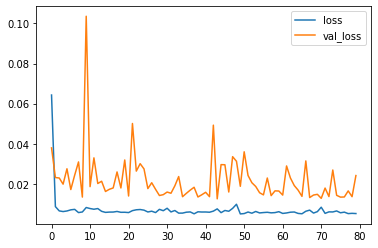

In [8]:
# plot accuracy per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


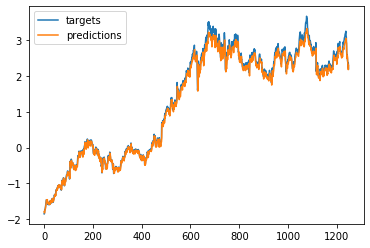

In [9]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

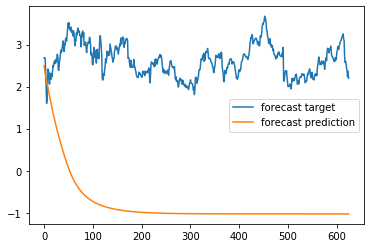

In [10]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [11]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1)  # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [12]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [13]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose'] 

In [14]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


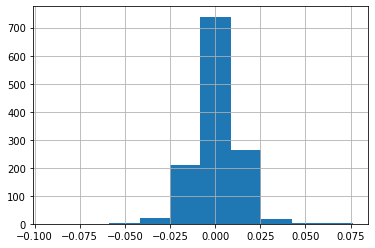

In [15]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [16]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [17]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [18]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1)
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 624 samples, validate on 624 samples
Epoch 1/80
624/624 [==============================] - 2s 3ms/sample - loss: 1.0112 - val_loss: 1.2172
Epoch 2/80
624/624 [==============================] - 0s 289us/sample - loss: 1.0122 - val_loss: 1.1594
Epoch 3/80
624/624 [==============================] - 0s 297us/sample - loss: 0.9979 - val_loss: 1.1605
Epoch 4/80
624/624 [==============================] - 0s 315us/sample - loss: 0.9897 - val_loss: 1.1520
Epoch 5/80
624/624 [==============================] - 0s 294us/sample - loss: 0.9899 - val_loss: 1.1727
Epoch 6/80
624/624 [==============================] - 0s 278us/sample - loss: 0.9737 - val_loss: 1.2516
Epoch 7/80
624/624 [==============================] - 0s 278us/sample - loss: 1.0057 - val_loss: 1.1484
Epoch 8/80
624/624 [==============================] - 0s 275us/sample - loss: 0.9796 - val_loss: 1.1833
Epoch 9/80
624/624 [==============================] - 0s 284us/sample - loss: 0.9785 - val_loss: 1.1841
Epoch 10/80
624/624 

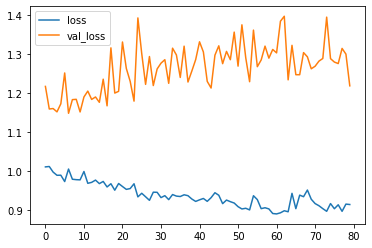

In [19]:
# plot accuracy per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


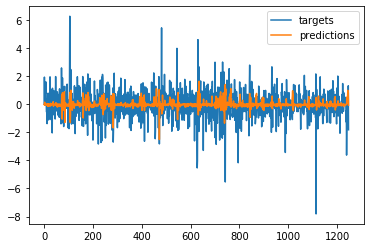

In [20]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

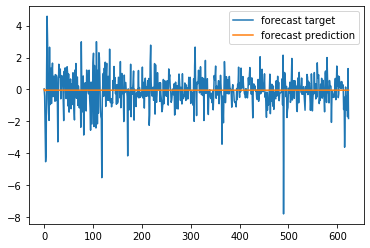

In [21]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [22]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [23]:
# Now make the actual data which will go into the nerual network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 same thing)

In [24]:
# normalize the inputs
Ntrain = len(input_data) * 2// 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [25]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [26]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N -Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N-Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [27]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)


In [28]:
# train the RNN
r = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test, Y_test),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 839 samples, validate on 410 samples
Epoch 1/300
839/839 [==============================] - 2s 2ms/sample - loss: 0.6952 - accuracy: 0.5125 - val_loss: 0.7084 - val_accuracy: 0.4854
Epoch 2/300
839/839 [==============================] - 0s 314us/sample - loss: 0.6944 - accuracy: 0.5054 - val_loss: 0.6959 - val_accuracy: 0.4854
Epoch 3/300
839/839 [==============================] - 0s 325us/sample - loss: 0.6923 - accuracy: 0.5125 - val_loss: 0.6933 - val_accuracy: 0.4927
Epoch 4/300
839/839 [==============================] - 0s 290us/sample - loss: 0.6893 - accuracy: 0.5328 - val_loss: 0.6975 - val_accuracy: 0.4878
Epoch 5/300
839/839 [==============================] - 0s 281us/sample - loss: 0.6899 - accuracy: 0.5328 - val_loss: 0.6939 - val_accuracy: 0.4927
Epoch 6/300
839/839 [==============================] - 0s 273us/sample - loss: 0.6888 - accuracy: 0.5435 - val_loss: 0.6938 - v

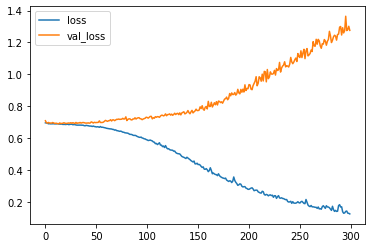

In [29]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

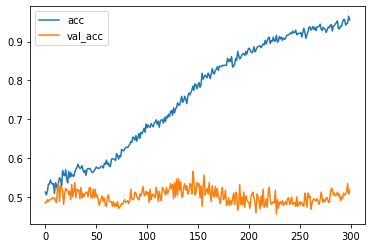

In [30]:
# plot the loss
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()